### Library imports

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import os
from collections import defaultdict
from scipy.ndimage import binary_erosion, binary_dilation
from scipy.ndimage import zoom

### Path configurations

In [2]:
BASE_DIR = r'C:\Users\LENOVO\VD\Project'

CONFLICTS_BASE = os.path.join(BASE_DIR, 'conflicts')
FSD_CONFLICT_DIR = os.path.join(CONFLICTS_BASE, 'FSD', 'zero_sum_patches', 'real')
HGR_CONFLICT_DIR = os.path.join(CONFLICTS_BASE, 'HGR', 'zero_sum_patches', 'real')
SFA_CONFLICT_DIR = os.path.join(CONFLICTS_BASE, 'SFA', 'zero_sum_patches', 'real')

conflict_dirs = {
    'FSD': FSD_CONFLICT_DIR,
    'HGR': HGR_CONFLICT_DIR,
    'SFA': SFA_CONFLICT_DIR
}

CSV_BASE = os.path.join(BASE_DIR, 'csv')

### Game solving function

In [3]:
def solve_zero_sum_value(A):
    """Solve zero-sum game for payoff matrix A, return game value v"""
    if A.size == 0:
        return 0.0
    m, n = A.shape
    if m == 0 or n == 0:
        return 0.0
    
    c = np.zeros(1 + m)
    c[0] = -1
    
    A_ub = np.hstack((-np.ones((n, 1)), A.T))
    b_ub = np.zeros(n)
    
    A_eq = np.zeros((1, 1 + m))
    A_eq[0, 1:] = 1
    b_eq = np.array([1.0])
    
    bounds = [(None, None)] + [(0, None)] * m
    
    res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, 
                  bounds=bounds, method='highs')
    
    if res.success:
        return -res.fun
    else:
        row_mins = np.min(A, axis=1)
        best_of_worst = np.max(row_mins)
         
        col_maxs = np.max(A, axis=0)
        worst_of_best = np.min(col_maxs)

        return (best_of_worst + worst_of_best) / 2


### Conflict Resolution and labels merging

In [4]:
for ds in ['FSD', 'HGR', 'SFA']:
    print(f"\n")
    print(f"Processing dataset: {ds}")
    
    # 1. Load classifier results

    csv_dir = os.path.join(CSV_BASE, ds)
    if not os.path.exists(csv_dir):
        print(f"Warning: Classifier dir not found: {csv_dir}")
        continue
    
    clfs = {}
    for clf_name in ['ANN', 'HSV', 'RGB']:
        csv_path = os.path.join(csv_dir, f'{clf_name.lower()}_results_{ds}.csv')
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path).set_index('image_patch')
            clfs[clf_name] = df
            print(f"Loaded {clf_name}: {len(df)} patches")
        else:
            print(f"Missing: {csv_path}")
    
    if len(clfs) != 3:
        print(f"Only {len(clfs)}/3 classifiers loaded → skipping {ds}")
        continue
    
    # 2. Get all unique patches

    all_patches = clfs['RGB'].index.unique()
    print(f"Total patches in {ds}: {len(all_patches)}")
    
    # 3. Identify non-conflict patches

    non_conflict_labels = {}
    conflict_patches = []
    
    for patch_full in all_patches:
        try:
            ann_label = clfs['ANN'].loc[patch_full, 'label_ann']
            hsv_label = clfs['HSV'].loc[patch_full, 'label_hsv']
            rgb_label = clfs['RGB'].loc[patch_full, 'label_rgb']
            
            labels = [ann_label, hsv_label, rgb_label]
            
            if len(set(labels)) == 1:
                clean_patch = os.path.basename(patch_full)
                non_conflict_labels[clean_patch] = labels[0]
            else:
                conflict_patches.append(patch_full)
        except KeyError:
            continue
    
    print(f"Non-conflict patches: {len(non_conflict_labels)}")
    print(f"Conflict patches (from classifiers): {len(conflict_patches)}")
    
    # 4. Load and process conflict CSV files

    conflict_dir = conflict_dirs.get(ds, '')
    if not os.path.exists(conflict_dir):
        print(f"Conflict dir not found: {conflict_dir}")
        continue
    
    csv_files = [f for f in os.listdir(conflict_dir) if f.endswith('.csv')]
    print(f"Found {len(csv_files)} conflict CSV files")
    
    conflict_labels = {}
    processed_conflicts = 0
    skipped_conflicts = 0
    
    for csv_file in csv_files:
        full_csv = os.path.join(conflict_dir, csv_file)
        try:
            df = pd.read_csv(full_csv, index_col=0)
            
            if 'region_path' not in df.columns or 'real_label' not in df.columns:
                print(f"Skipping malformed CSV: {csv_file}")
                skipped_conflicts += 1
                continue
            
            patch_path_full = df['region_path'].iloc[0]
            clean_patch_name = os.path.basename(patch_path_full)
            real_label = df['real_label'].iloc[0]
            
            # Extract payoff matrix
            meta_cols = ['region_path', 'real_label']
            payoff_cols = [c for c in df.columns if c not in meta_cols]
            
            if len(payoff_cols) == 0:
                print(f"No payoff columns in {csv_file}")
                skipped_conflicts += 1
                continue
            
            A = df[payoff_cols].values.astype(float)
            
            # Solve the game
            v = solve_zero_sum_value(A)
            label = 1 if v > 0 else 0
            
            conflict_labels[clean_patch_name] = label
            processed_conflicts += 1
            
        except Exception as e:
            print(f"Error processing {csv_file}: {str(e)[:100]}...")
            skipped_conflicts += 1
            continue
    
    print(f"Resolved {processed_conflicts} conflicts")
    if skipped_conflicts > 0:
        print(f"Skipped {skipped_conflicts} conflict CSVs due to errors")
    

    # 5. Handle missing conflict patches
    
    missing_conflict_labels = {}
    
    for patch_full in conflict_patches:
        clean_patch = os.path.basename(patch_full)
        
        if clean_patch in conflict_labels:
            continue
        
        if clean_patch in non_conflict_labels:
            continue
        
        try:
            ann_label = clfs['ANN'].loc[patch_full, 'label_ann']
            hsv_label = clfs['HSV'].loc[patch_full, 'label_hsv']
            rgb_label = clfs['RGB'].loc[patch_full, 'label_rgb']
            
            # Majority vote
            sum_labels = ann_label + hsv_label + rgb_label
            label = 1 if sum_labels >= 2 else 0
            
            missing_conflict_labels[clean_patch] = label
        except KeyError:
            continue
    
    if missing_conflict_labels:
        print(f"Added {len(missing_conflict_labels)} missing conflicts via majority vote")
    
    # 6. Merge all labels
    
    all_labels = {}
    
    all_labels.update(non_conflict_labels)
    
    all_labels.update(conflict_labels)
    
    all_labels.update(missing_conflict_labels)
    
    # 7. Verify we have all patches

    # Each image should have 256 patches (16×16 grid)
    patch_counts = {}
    for patch_name in all_labels.keys():
        if '_' in patch_name:
            img_id = patch_name.split('_')[0]
            patch_counts[img_id] = patch_counts.get(img_id, 0) + 1
    
    missing_images = []
    for img_id in sorted(patch_counts.keys()):
        if patch_counts[img_id] != 256:
            missing_images.append((img_id, patch_counts[img_id]))
    
    if missing_images:
        print(f"Some images missing patches: {missing_images[:5]}")
    
    # 8. Save results

    save_path = os.path.join(BASE_DIR, f'{ds}_all_labels_FIXED.npy')
    np.save(save_path, all_labels)
    
    print(f"\nSaved {len(all_labels)} patch labels to: {save_path}")
    print(f"  Non-conflict: {len(non_conflict_labels)}")
    print(f"  Game-resolved conflicts: {len(conflict_labels)}")
    print(f"  Majority-vote conflicts: {len(missing_conflict_labels)}")
    
    print(f"  Skin patches: {sum(all_labels.values())}")
    print(f"  Non-skin patches: {len(all_labels) - sum(all_labels.values())}")

print("\n")
print("PROCESSING COMPLETE")



Processing dataset: FSD
Loaded ANN: 28160 patches
Loaded HSV: 28160 patches
Loaded RGB: 28160 patches
Total patches in FSD: 28160
Non-conflict patches: 20418
Conflict patches (from classifiers): 7742
Found 7742 conflict CSV files
Resolved 7742 conflicts

Saved 28160 patch labels to: C:\Users\LENOVO\VD\Project\FSD_all_labels_FIXED.npy
  Non-conflict: 20418
  Game-resolved conflicts: 7742
  Majority-vote conflicts: 0
  Skin patches: 8692
  Non-skin patches: 19468


Processing dataset: HGR
Loaded ANN: 28160 patches
Loaded HSV: 28160 patches
Loaded RGB: 28160 patches
Total patches in HGR: 28160
Non-conflict patches: 21335
Conflict patches (from classifiers): 6825
Found 8549 conflict CSV files
Resolved 8549 conflicts

Saved 28160 patch labels to: C:\Users\LENOVO\VD\Project\HGR_all_labels_FIXED.npy
  Non-conflict: 21335
  Game-resolved conflicts: 6825
  Majority-vote conflicts: 0
  Skin patches: 8992
  Non-skin patches: 19168


Processing dataset: SFA
Loaded ANN: 28160 patches
Loaded HSV: 

### Estimating false positives

In [5]:
print("Estimating false positives (skin but majority classifiers said non-skin)")

basename_to_full = {os.path.basename(p): p for p in clfs['RGB'].index}
print(f"Lookup dictionary built: {len(basename_to_full)} entries")

fp_count = 0
total_patches = len(all_labels)

for patch_name, your_label in all_labels.items():
    if your_label == 0:
        continue
    
    full_patch = basename_to_full.get(patch_name)
    if full_patch is None:
        continue
    
    try:
        lbls = [clfs[name].loc[full_patch, f'label_{name.lower()}'] for name in clfs]
        non_skin_votes = sum(1 for l in lbls if l == 0)
        if non_skin_votes >= 2:
            fp_count += 1
    except KeyError:
        continue

fp_rate = fp_count / total_patches * 100 if total_patches > 0 else 0
print(f"\nEstimated false positives: {fp_count} / {total_patches} patches ({fp_rate:.2f}%)")

Estimating false positives (skin but majority classifiers said non-skin)
Lookup dictionary built: 28160 entries

Estimated false positives: 1541 / 28160 patches (5.47%)


In [6]:
BASE_DIR = r'C:\Users\LENOVO\VD\Project'

BASE_PROCESSED = os.path.join(BASE_DIR, 'data2', 'processed')

datasets = {
    'FSD': {
        'original_dir': os.path.join(BASE_PROCESSED, 'data2_FSD', 'real'),
        'mask_dir':     os.path.join(BASE_DIR, 'masks_FSD_FIXED'),
        'ext': '.png'
    },
    'SFA': {
        'original_dir': os.path.join(BASE_PROCESSED, 'data3_SFA', 'real'),
        'mask_dir':     os.path.join(BASE_DIR, 'masks_SFA_FIXED'),
        'ext': '.png'
    },
    'HGR': {
        'original_dir': os.path.join(BASE_PROCESSED, 'data4_HGR', 'real'),
        'mask_dir':     os.path.join(BASE_DIR, 'masks_HGR_FIXED'),
        'ext': '.png'
    }
}

### Building the masks

In [7]:
PATCH_SIZE = 18
GRID_COLS  = 16

VISUALIZATION_DIR = os.path.join(BASE_DIR, 'visualizations')
os.makedirs(VISUALIZATION_DIR, exist_ok=True)

for ds in ['FSD', 'HGR', 'SFA']:
    print(f"Processing dataset: {ds}")
    
    # 1. Load labels
    labels_path = os.path.join(BASE_DIR, f'{ds}_all_labels_FIXED.npy')
    if not os.path.exists(labels_path):
        print(f"FIXED labels missing")
        labels_path = os.path.join(BASE_DIR, f'{ds}_all_labels.npy')
        if not os.path.exists(labels_path):
            print(f"No labels found for {ds}")
            continue
    
    all_labels = np.load(labels_path, allow_pickle=True).item()
    print(f"Loaded {len(all_labels)} patch labels")
    
    # 2. Create final mask folder
    FINAL_MASK_DIR = os.path.join(BASE_DIR, f'masks_{ds}_final')
    os.makedirs(FINAL_MASK_DIR, exist_ok=True)
    
    # 3. Group patches by image ID
    images = defaultdict(dict)
    
    for patch_name, label in all_labels.items():
        base = patch_name.replace('.png', '')
        if '_' not in base:
            continue
        img_id, idx_str = base.split('_')
        try:
            patch_idx = int(idx_str)
        except ValueError:
            continue
        
        row = patch_idx // GRID_COLS
        col = patch_idx % GRID_COLS
        
        row_px = row * PATCH_SIZE
        col_px = col * PATCH_SIZE
        
        images[img_id][(row_px, col_px)] = label
    
    print(f"Found {len(images)} images")
    
    # 4. Build mask and visualization for all images
    processed_count = 0
    
    # Get original images
    orig_dir = datasets[ds]['original_dir']
    ext = datasets[ds]['ext']
    original_files = sorted([f for f in os.listdir(orig_dir) if f.endswith(ext)])
    
    print(f"Found {len(original_files)} original images")
    
    for file in original_files:
        img_id = file.replace(ext, '')
        orig_path = os.path.join(orig_dir, file)
        
        if img_id not in images:
            print(f" no patch labels for {img_id} ")
            continue
        
        pos_dict = images[img_id]
        
        # Build mask
        max_r = max(r for r, c in pos_dict) + PATCH_SIZE if pos_dict else 288
        max_c = max(c for r, c in pos_dict) + PATCH_SIZE if pos_dict else 288
        
        mask = np.zeros((max_r, max_c), dtype=np.uint8)
        
        missing = 0
        for idx in range(256):
            row = idx // GRID_COLS
            col = idx % GRID_COLS
            r_px = row * PATCH_SIZE
            c_px = col * PATCH_SIZE
            pos = (r_px, c_px)
            if pos in pos_dict:
                mask[r_px:r_px+PATCH_SIZE, c_px:c_px+PATCH_SIZE] = pos_dict[pos]
            else:
                missing += 1
        
        if missing > 0:
            print(f"{img_id}: {missing} missing patches")
        
        # Post-processing
        try:
            cleaned_mask = binary_erosion(mask, iterations=1)
            cleaned_mask = binary_dilation(cleaned_mask, iterations=2)
        except ImportError:
            cleaned_mask = mask
        
        # Save mask
        mask_npy_path = os.path.join(FINAL_MASK_DIR, f'mask_{img_id}.npy')
        np.save(mask_npy_path, cleaned_mask)
        
        # Visualization
        try:
            original = plt.imread(orig_path)
            if original.shape[:2] != cleaned_mask.shape:
                zoom_factors = (cleaned_mask.shape[0] / original.shape[0],
                                cleaned_mask.shape[1] / original.shape[1], 1)
                original = zoom(original, zoom_factors)
            
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            
            axs[0].imshow(original)
            axs[0].set_title(f'Original: {ds} {img_id}')
            axs[0].axis('off')
            
            axs[1].imshow(cleaned_mask, cmap='gray')
            axs[1].set_title('Final Mask')
            axs[1].axis('off')
            
            overlay = original.copy()
            overlay[cleaned_mask == 1] = overlay[cleaned_mask == 1] * 0.6 + np.array([1.0, 0.3, 0.3]) * 0.4
            axs[2].imshow(overlay)
            axs[2].set_title('Final Overlay (Skin in Red)')
            axs[2].axis('off')
            
            plt.tight_layout()
            
            viz_png_path = os.path.join(FINAL_MASK_DIR, f'mask_{img_id}.png')
            plt.savefig(viz_png_path, dpi=150, bbox_inches='tight')
            plt.close(fig)
            
            processed_count += 1
            
            if processed_count % 10 == 0:
                print(f" Processed {processed_count} images")
                
        except Exception as e:
            print(f"Error on {img_id}: {str(e)[:100]}")
            continue
    
    print(f"{processed_count} images fully processed")

Processing dataset: FSD
Loaded 28160 patch labels
Found 110 images
Found 110 original images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.025557509..0.92772144].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.025557509..0.94924176].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.036824457..0.9425379].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03640396..0.94888186].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.027422681..0.9214977].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.027422681..0.9528986].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got ra

 Processed 10 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11319051..0.96045345].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11319051..0.965035].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.027629156..0.9222165].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.027629156..0.9222165].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.049321964..0.95460033].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03285492..0.9727602].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range 

 Processed 20 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0035728884..0.91704345].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07780105..0.9159433].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07780105..0.9159433].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03131072..0.9421122].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03131072..0.9652673].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0840572..0.9385248].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-

 Processed 30 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.040054373..0.9416281].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.040054373..0.91025156].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04483798..0.902815].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04483798..0.902815].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.045239646..0.9007495].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.045239646..0.9007495].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [

 Processed 40 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.031394612..0.9461161].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.031394612..0.9461161].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07937113..0.99926096].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07937113..0.99926096].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.046262924..0.9186103].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.019218067..0.928917].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range

 Processed 50 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03184037..0.9077221].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03008883..0.9297573].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.061593447..0.95390964].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.061593447..0.95390964].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.107787065..0.9678755].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.107787065..0.9678755].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got rang

 Processed 60 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0838907..0.9695899].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0838907..0.9695899].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04932413..0.9663373].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04932413..0.9663373].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.082792826..0.99002075].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.082792826..0.99002075].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-

 Processed 70 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.044890508..0.9480184].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.044890508..0.96881104].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.033780787..0.9621752].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.025972389..0.9754708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07643427..0.9815581].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07643427..0.9815581].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range

 Processed 80 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.063821614..0.9687498].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.063821614..0.9687498].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.035345774..0.90205395].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03177961..0.9412324].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1206721..0.9473771].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1206721..0.9473771].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-

 Processed 90 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.058746252..0.88981897].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.058746252..0.9270102].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04966749..0.9136337].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04966749..0.9481802].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.037979133..0.9148268].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.037979133..0.94506866].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got rang

 Processed 100 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03242512..0.8373718].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0058567706..0.9024231].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02338037..0.89327383].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02283101..0.90997136].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.014512922..0.90046525].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0067873267..0.93189985].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got r

 Processed 110 images
110 images fully processed
Processing dataset: HGR
Loaded 28160 patch labels
Found 110 images
Found 110 original images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.008258913..0.6533189].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.008258913..0.79199135].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0012406127..0.6657909].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0012406127..0.79705817].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0037576295..0.6157106].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.000284707..0.76942635].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Go

 Processed 10 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.013556509..0.79103756].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.014835686..0.64203393].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0077574598..0.7852204].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003962375..0.45746818].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003962375..0.6744809].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.009747045..0.5249186].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got 

 Processed 20 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0033616931..0.8638014].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0022860062..0.8447497].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.022574252..0.89469016].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.012684656..0.93681407].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.028307315..0.7868661].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.017938038..0.87211967].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got

 Processed 30 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0056823064..0.62943393].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0038035484..0.6861676].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0038035484..0.8117006].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0009690646..0.63187116].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0009690646..0.7791227].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003621429..0.6402398].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). G

 Processed 40 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0130164595..0.81660414].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0049786046..0.81660414].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.008931165..0.68089724].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0026341008..0.8085384].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.010256035..0.69333637].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.006456539..0.81600183].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). 

 Processed 50 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.012468549..0.58245414].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.008489118..0.7494725].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.008547582..0.6918544].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.018540021..0.7930158].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.018540021..0.8758095].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.031419434..0.67631143].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got ra

 Processed 60 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.012296406..0.6412642].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.006944828..0.7847585].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.012392685..0.6237049].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.012392685..0.77422297].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.010910137..0.68400234].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0084310435..0.81040144].


 Processed 70 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0057948474..0.91304743].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0042134444..0.923059].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.010093888..0.91483235].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.006554945..0.9300054].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.011573187..0.66774416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0041889753..0.8006465].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got

 Processed 80 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0054054703..0.8838784].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.012393809..0.8654147].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.001380749..0.9192488].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0066922824..0.8123807].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00531038..0.8874284].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.008481017..0.7658784].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got ran

 Processed 90 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.007288318..0.8811283].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.007288318..0.92867696].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0012609415..0.78791535].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0005274673..0.8727492].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0053292825..0.86833227].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0026543273..0.86833227].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). 

 Processed 100 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.01147647..0.7061848].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.01147647..0.8237109].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0077203377..0.68663734].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0077203377..0.8119824].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.005166676..0.72616154].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.005166676..0.83569694].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got r

 Processed 110 images
110 images fully processed
Processing dataset: SFA
Loaded 28160 patch labels
Found 110 images
Found 110 original images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.056424595..0.9889331].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.056424595..0.99335986].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0043828683..1.0108913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0043828683..1.0108913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.006566281..1.0089333].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.006566281..1.0089333].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got r

 Processed 10 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.056424733..0.9783405].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05592999..0.9948906].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05592999..0.9948906].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05440773..1.0262152].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05440773..1.0262152].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.056062553..0.9853435].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-

 Processed 20 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.008794262..1.0061587].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.000407802..1.0265937].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.000407802..1.0265937].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.006817832..1.0048671].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.006817832..1.0048671].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.005201036..1.0126753].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got rang

 Processed 30 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04444522..1.036817].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04444522..1.036817].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1076682..1.0425146].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1076682..1.0425146].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.043782577..1.0183796].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.011467764..1.0110278].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.038

 Processed 40 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.021398427..1.004414].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03621695..0.96843785].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.009400046..0.96843785].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.011061099..1.0228972].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.015171641..1.0219656].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.024203932..0.99419606].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range

 Processed 50 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02667684..0.9861999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02667684..0.9861999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.10106426..1.0050972].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.10106426..1.0050972].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.034736596..1.0296155].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.034736596..1.0296155].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.092

 Processed 60 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.03395436..1.0018378].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.03395436..1.0018378].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.047291864..1.0324565].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.047291864..1.0324565].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.026695026..1.0460712].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.026695026..1.0174205].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.038

 Processed 70 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06805134..1.0091867].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06805134..1.0091867].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.020657245..1.0120654].


 Processed 80 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.024040382..0.96192276].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.013145698..0.96192276].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.030251516..1.0045811].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.012629772..1.0018622].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.012629772..0.98567903].


 Processed 90 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.021061044..1.0017798].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.021061044..1.0017798].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.07081003..1.0657738].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.07081003..1.0657738].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0012408198..1.001585].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0012408198..1.001585].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.

 Processed 100 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0029532341..1.0082524].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0029532341..1.0082524].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00949741..1.0140959].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00949741..1.0033387].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.002052587..1.0124466].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.002052587..1.0124466].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range 

 Processed 110 images
110 images fully processed


### Evaluation IoU and visualization

In [8]:
BASE_DIR = r'C:\Users\LENOVO\VD\Project'
BASE_PROCESSED = os.path.join(BASE_DIR, 'data2', 'processed')

datasets = {
    'FSD': {
        'original_dir': os.path.join(BASE_PROCESSED, 'data2_FSD', 'real'),
        'your_mask_dir': os.path.join(BASE_DIR, 'masks_FSD_final'),
        'gt_mask_dir': os.path.join(BASE_PROCESSED, 'data2_FSD', 'mask'),
        'ext': '.png'
    },
    'SFA': {
        'original_dir': os.path.join(BASE_PROCESSED, 'data3_SFA', 'real'),
        'your_mask_dir': os.path.join(BASE_DIR, 'masks_SFA_final'),
        'gt_mask_dir': os.path.join(BASE_PROCESSED, 'data3_SFA', 'mask'),
        'ext': '.png'
    },
    'HGR': {
        'original_dir': os.path.join(BASE_PROCESSED, 'data4_HGR', 'real'),
        'your_mask_dir': os.path.join(BASE_DIR, 'masks_HGR_final'),
        'gt_mask_dir': os.path.join(BASE_PROCESSED, 'data4_HGR', 'mask'),
        'ext': '.png'
    }
}

IOU_RESULTS_DIR = os.path.join(BASE_DIR, 'iou_results')
os.makedirs(IOU_RESULTS_DIR, exist_ok=True)

SUMMARY_FILE = os.path.join(IOU_RESULTS_DIR, 'iou_summary.txt')

### IoU function

In [9]:
def compute_iou(your_mask, gt_mask):
    your_bin = (your_mask >= 0.5).astype(np.uint8)
    gt_bin = (gt_mask >= 0.5).astype(np.uint8)
   
    intersection = np.logical_and(your_bin, gt_bin).sum()
    union = np.logical_or(your_bin, gt_bin).sum()
   
    return intersection / union if union > 0 else 0.0

IoU Evaluation & Visualization

Evaluating FSD
Found 110 images
  Resizing GT 001
  Image 001: IoU = 0.5516


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_3328\2088129249.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


  Resizing GT 002
  Image 002: IoU = 0.6282
  Resizing GT 003
  Image 003: IoU = 0.6472
  Resizing GT 004
  Image 004: IoU = 0.7635
  Resizing GT 005
  Image 005: IoU = 0.1995
  Resizing GT 006
  Image 006: IoU = 0.6235
  Resizing GT 007
  Image 007: IoU = 0.7425
  Resizing GT 008
  Image 008: IoU = 0.2003
  Resizing GT 009
  Image 009: IoU = 0.6345
  Resizing GT 010
  Image 010: IoU = 0.5487
  Resizing GT 011
  Image 011: IoU = 0.6048
  Resizing GT 012
  Image 012: IoU = 0.7651
  Resizing GT 013
  Image 013: IoU = 0.2624
  Resizing GT 014
  Image 014: IoU = 0.3802
  Resizing GT 015
  Image 015: IoU = 0.5358
  Resizing GT 016
  Image 016: IoU = 0.4659
  Resizing GT 017
  Image 017: IoU = 0.1518
  Resizing GT 018
  Image 018: IoU = 0.2484
  Resizing GT 019
  Image 019: IoU = 0.8317
  Resizing GT 020
  Image 020: IoU = 0.6634
  Resizing GT 021
  Image 021: IoU = 0.3399
  Resizing GT 022
  Image 022: IoU = 0.3771
  Resizing GT 023
  Image 023: IoU = 0.1748
  Resizing GT 024
  Image 024: I

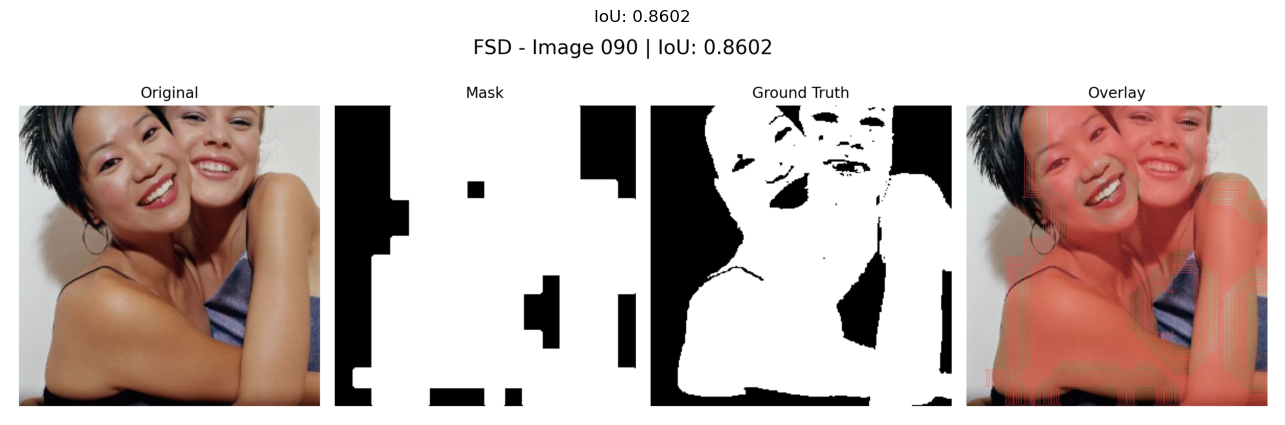


Visualization for SFA (IoU 0.9003): iou_eval_SFA_062.png


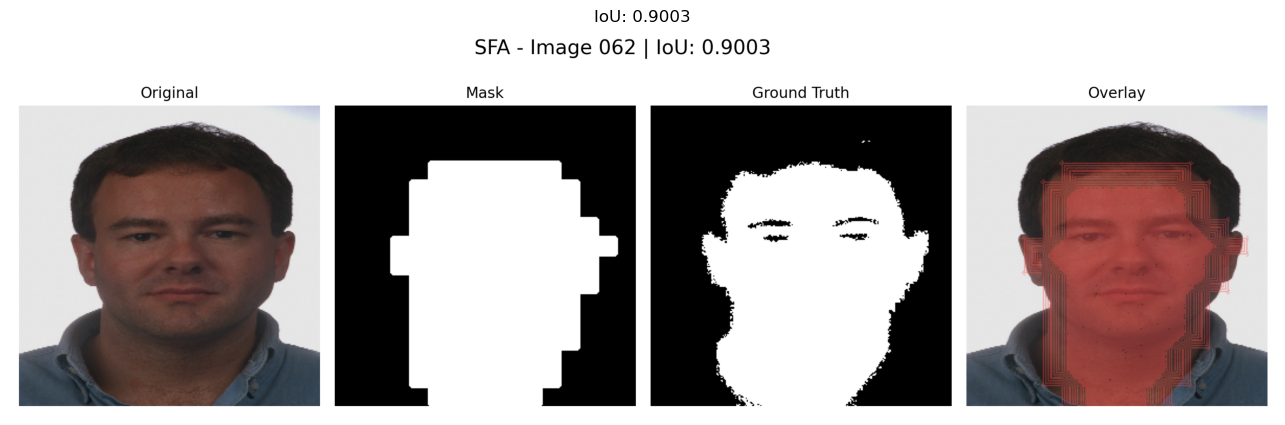


Visualization for HGR (IoU 0.8950): iou_eval_HGR_080.png


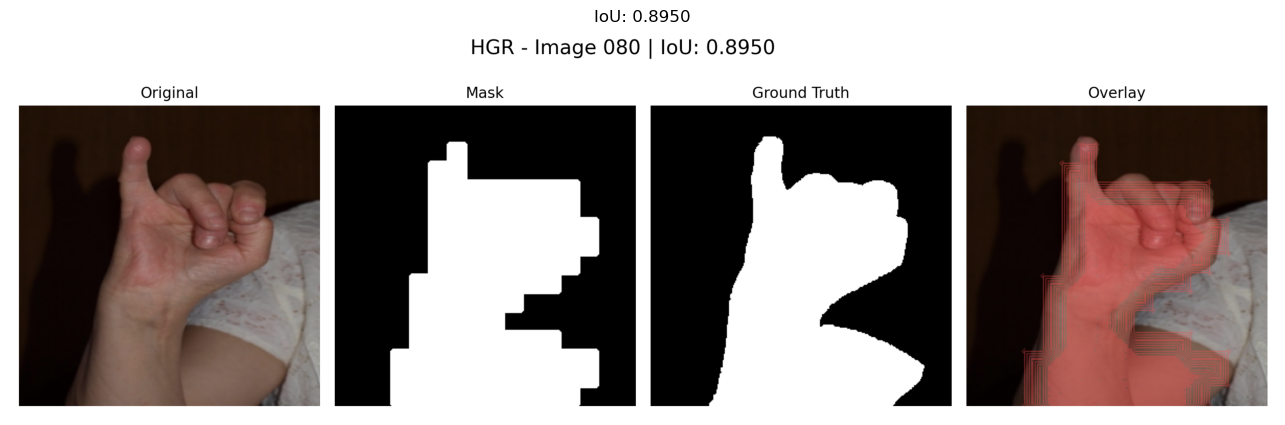

In [10]:
print("IoU Evaluation & Visualization")

iou_results = {}
summary_lines = ["IoU Evaluation Summary \n"+ "\n"]

best_iou_per_ds = {}
best_iou_path_per_ds = {}

for ds_name, paths in datasets.items():
    orig_dir = paths['original_dir']
    your_dir = paths['your_mask_dir']
    gt_dir = paths['gt_mask_dir']
    ext = paths['ext']
   
    if not all(os.path.exists(d) for d in [orig_dir, your_dir, gt_dir]):
        print(f"\n{ds_name}: Missing directory")
        continue
   
    print(f"\nEvaluating {ds_name}")
    iou_scores = []
    ds_lines = [f"\n{ds_name}:\n" + "\n"]
    best_iou = -1
    best_img_id = None
    best_save_path = None
   
    image_files = sorted([f for f in os.listdir(orig_dir) if f.endswith(ext)])
    print(f"Found {len(image_files)} images")
   
    for file in image_files:
        img_id = file.replace(ext, '')
        orig_path = os.path.join(orig_dir, file)
        your_path = os.path.join(your_dir, f'mask_{img_id}.npy')
        gt_path = os.path.join(gt_dir, f'{img_id}{ext}')
       
        missing = [k for k, p in [('original', orig_path), ('your mask', your_path), ('GT', gt_path)] if not os.path.exists(p)]
        if missing:
            print(f" missing: {', '.join(missing)}")
            continue
       
        try:
            original = plt.imread(orig_path)
            your_mask = np.load(your_path)
            gt_img = plt.imread(gt_path)
           
            gt_mask = gt_img.mean(axis=-1) if len(gt_img.shape) == 3 else gt_img
            gt_mask = (gt_mask > 0.5).astype(np.uint8)
           
            if gt_mask.shape != your_mask.shape:
                print(f"  Resizing GT {img_id}")
                zoom_factors = (your_mask.shape[0] / gt_mask.shape[0],
                                your_mask.shape[1] / gt_mask.shape[1])
                gt_mask = zoom(gt_mask, zoom_factors)
           
            iou = compute_iou(your_mask, gt_mask)
            iou_scores.append(iou)
           
            print(f"  Image {img_id}: IoU = {iou:.4f}")
            ds_lines.append(f"  Image {img_id}: IoU = {iou:.4f}\n")
           
            if iou > best_iou:
                best_iou = iou
                best_img_id = img_id
            
            fig = plt.figure(figsize=(18, 5))
            gs = fig.add_gridspec(1, 4, wspace=0.05)
           
            ax0 = fig.add_subplot(gs[0, 0])
            ax0.imshow(original)
            ax0.set_title('Original')
            ax0.axis('off')
           
            ax1 = fig.add_subplot(gs[0, 1])
            ax1.imshow(your_mask, cmap='gray')
            ax1.set_title('Mask')
            ax1.axis('off')
           
            ax2 = fig.add_subplot(gs[0, 2])
            ax2.imshow(gt_mask, cmap='gray')
            ax2.set_title('Ground Truth')
            ax2.axis('off')
           
            ax3 = fig.add_subplot(gs[0, 3])
           
            if original.shape[:2] != your_mask.shape:
                zoom_y = original.shape[0] / your_mask.shape[0]
                zoom_x = original.shape[1] / your_mask.shape[1]
                your_mask_resized = zoom(your_mask, (zoom_y, zoom_x))
            else:
                your_mask_resized = your_mask.copy()
           
            if len(original.shape) == 3:
                overlay = original.astype(np.float32) / 255 if original.max() > 1 else original.copy().astype(np.float32)
            else:
                overlay = np.stack([original] * 3, axis=-1).astype(np.float32)
                if original.max() > 1:
                    overlay = overlay / 255
           
            mask_indices = your_mask_resized >= 0.5
            if len(overlay.shape) == 3:
                overlay[mask_indices] = overlay[mask_indices] * 0.6 + np.array([1.0, 0.3, 0.3]) * 0.4
           
            ax3.imshow(overlay)
            ax3.set_title('Overlay')
            ax3.axis('off')
           
            plt.suptitle(f"{ds_name} - Image {img_id} | IoU: {iou:.4f}", fontsize=16)
            plt.tight_layout()
            
            # SAVE
            save_path = os.path.join(IOU_RESULTS_DIR, f'iou_eval_{ds_name}_{img_id}.png')
            plt.savefig(save_path, dpi=200, bbox_inches='tight')
            plt.close(fig)
           
            if iou == best_iou:
                best_save_path = save_path
           
        except Exception as e:
            print(f" Error on {img_id}: {str(e)[:150]}...")
            continue
   
    if iou_scores:
        avg_iou = np.mean(iou_scores)
        print(f" Average IoU for {ds_name} ({len(iou_scores)} images): {avg_iou:.4f}")
        iou_results[ds_name] = avg_iou
        ds_lines.append(f"  Average IoU: {avg_iou:.4f}\n")
        summary_lines.extend(ds_lines)
        
        best_iou_per_ds[ds_name] = best_iou
        best_iou_path_per_ds[ds_name] = best_save_path

summary_lines.append("\n" + "\nFinal Summary\n")
for ds, iou in iou_results.items():
    line = f"{ds}: Avg IoU = {iou:.4f}"
    summary_lines.append(line + "\n")

with open(SUMMARY_FILE, 'w') as f:
    f.writelines(summary_lines)

print("\n")
print("Final IoU Summary")
print("Saved to:", SUMMARY_FILE)
for ds, iou in iou_results.items():
    print(f"{ds}: Avg IoU = {iou:.4f}")

print("\n")

for ds_name in datasets.keys():
    if ds_name in best_iou_path_per_ds and best_iou_path_per_ds[ds_name]:
        best_path = best_iou_path_per_ds[ds_name]
        best_iou = best_iou_per_ds[ds_name]
        
        print(f"\nVisualization for {ds_name} (IoU {best_iou:.4f}): {os.path.basename(best_path)}")
        
        try:
            img = plt.imread(best_path)
            plt.figure(figsize=(18, 5))
            plt.imshow(img)
            plt.title(f"IoU: {best_iou:.4f}")
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"  Could not display best for {ds_name}: {e}")
    else:
        print(f"\nNo best visualization saved for {ds_name}")